# Noise and Error Mitigitation in Quantum Real Circuits 
## Basado en el siguiente tutorial:
https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/Coding_With_Qiskit/ep8_Noise_and_Error_Mitigation.ipynb

In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from qiskit import *

In [3]:
# Descomente la siguiente linea si desea ver las imágenes más grandes.
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

In [4]:
nqubits = 3
circuit = QuantumCircuit(nqubits, nqubits)
circuit.h(0)
circuit.cx(0,1)
circuit.cx(1,2)
circuit.measure([0,1,2], [0,1,2])

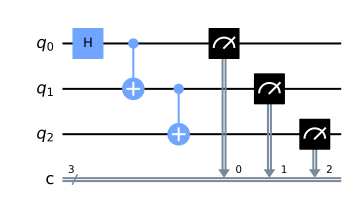

In [5]:
circuit.draw(output='mpl')

In [6]:
simulator = Aer.get_backend('qasm_simulator')
sim_result = execute(circuit, backend=simulator, shots=1024).result()

In [7]:
from qiskit.visualization import plot_histogram

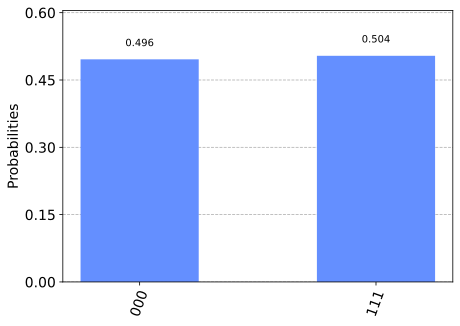

In [8]:
plot_histogram(sim_result.get_counts(circuit))

In [9]:
#IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q')
#device = provider.get_backend('ibmqx2')

In [10]:
# First, see what devices we are allowed to use by loading our saved accounts
IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q')
provider = IBMQ.get_provider(hub='ibm-q-education', group='uni-antioquia-1', project='qcudea2022-1')
#Remote_QProcessor = provider.get_backend('ibm_perth')
Remote_QSimulator = provider.get_backend('ibmq_qasm_simulator')

ibmqfactory.load_account:WARNING:2022-08-03 12:00:18,409: Credentials are already in use. The existing account in the session will be replaced.


In [11]:
#job = execute(circuit, backend=Remote_QProcessor, shots=1024)
job = execute(circuit, backend=Remote_QSimulator, shots=1024)
#print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


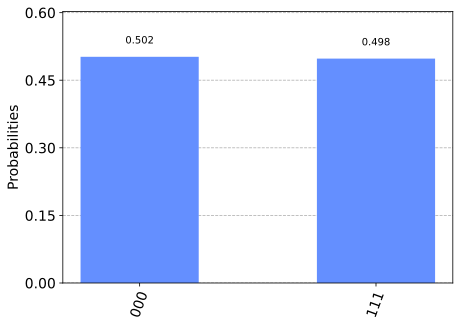

In [12]:
device_result = job.result()
plot_histogram(device_result.get_counts(circuit))

In [13]:
# Definition of Calibration Circuits to mitigate the measurement error.

In [15]:
#from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.utils.mitigation import (complete_meas_cal, tensored_meas_cal,
                                        CompleteMeasFitter, TensoredMeasFitter)

In [16]:
calibration_circuits, quantum_states = complete_meas_cal(qr=circuit.qregs[0], 
                                               circlabel='measurement_calibration')

In [17]:
quantum_states

['000', '001', '010', '011', '100', '101', '110', '111']

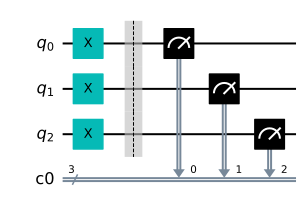

In [18]:
calibration_circuits[7].draw(output='mpl')

In [19]:
len(calibration_circuits)

8

In [20]:
cal_job = execute(calibration_circuits,
             backend=Remote_QSimulator,
             shots=8192,
             optimization_level=0)
#print(cal_job.job_id())
job_monitor(cal_job)
calibration_results = cal_job.result()

Job Status: job has successfully run


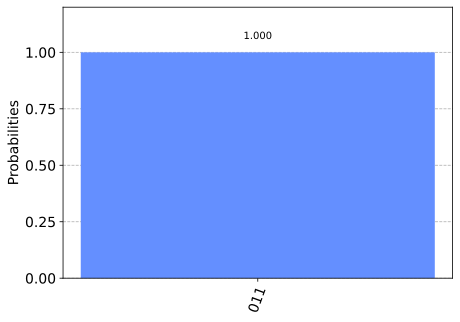

In [21]:
plot_histogram(calibration_results.get_counts(calibration_circuits[3]))

In [22]:
My_fitter = CompleteMeasFitter(calibration_results, quantum_states)

In [23]:
#My_fitter.plot_calibration()

In [24]:
Measurement_Filter = My_fitter.filter

# Mitigating the measurement errors in our previous device run

In [25]:
mitigated_result = Measurement_Filter.apply(device_result)

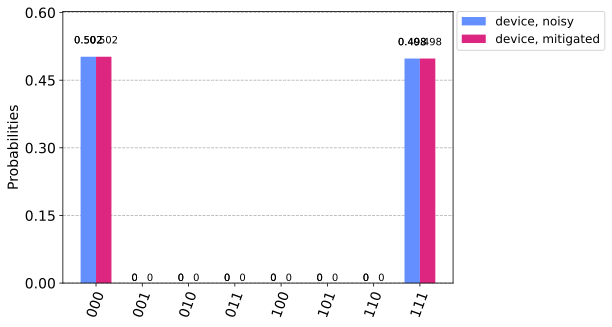

In [26]:
device_counts = device_result.get_counts(circuit)
mitigated_counts = mitigated_result.get_counts(circuit)
plot_histogram([device_counts, mitigated_counts], 
               legend=['device, noisy', 'device, mitigated'])

# Running error mitigation on a second circuit

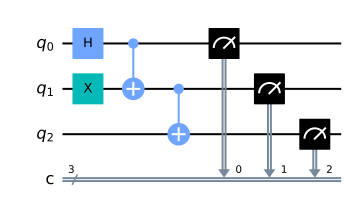

In [27]:
circuit2 = QuantumCircuit(3,3)
circuit2.x(1)
circuit2.h(0)
circuit2.cx(0,1)
circuit2.cx(1,2)
circuit2.measure([0,1,2], [0,1,2])
circuit2.draw(output='mpl')

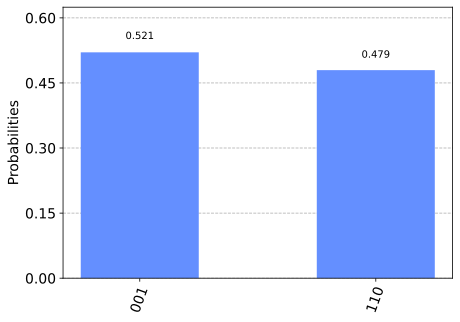

In [28]:
# Simulating the circuit and plotting the corresponding histogram:
Simulation_counts_2 = execute(circuit2, backend=simulator, shots=1024).result().get_counts(circuit2)
plot_histogram(Simulation_counts_2)

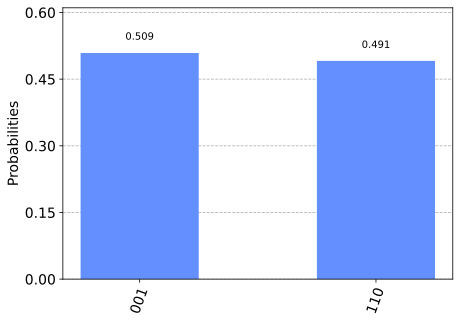

In [29]:
# Executing the circuit and plotting the corresponding histogram:
device_counts_2 = execute(circuit2, backend=Remote_QSimulator, shots=1024).result().get_counts(circuit2)
plot_histogram(device_counts_2)

In [30]:
mitigated_counts_2 = Measurement_Filter.apply(device_counts_2)

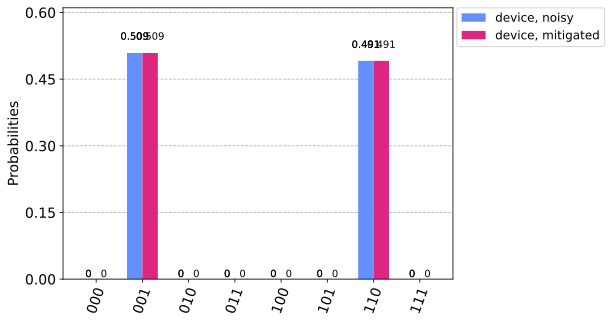

In [31]:
plot_histogram([device_counts_2, mitigated_counts_2], legend=['device, noisy','device, mitigated'])

In [32]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright